In [1]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import lwreg
from lwreg import utils,standardization_lib
import pandas as pd
import rdkit

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

# Start by reading in a data set from ChEMBL

In [2]:
df = pd.read_csv('../demos/demo_data/S1P1_data.csv')
df.head()

,doc_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,canonical_smiles,compound_chembl_id
0,5839,189018,=,82.0,nM,1,EC50,7.09,CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.O...,CHEMBL332050
1,5839,188442,=,322.1,nM,1,EC50,6.49,CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=...,CHEMBL115505
2,5839,188375,=,260.0,nM,1,EC50,6.58,CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=...,CHEMBL115344
3,5839,188376,=,598.4,nM,1,EC50,6.22,CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C...,CHEMBL324358
4,5839,188766,=,12.7,nM,1,EC50,7.90,CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)...,CHEMBL332472


# Generate conformers

Now we can go ahead and register ten unique molecules (we limit the size to allow the tutorial to run faster):

In [3]:
unique_smis = set()
mols = []
for smi in df.canonical_smiles:
    mol = Chem.AddHs(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smi)))
    smi = Chem.MolToSmiles(mol)
    if smi not in unique_smis:
        mols.append(mol)
        unique_smis.add(smi)
    if len(unique_smis) >= 10:
        break

In [4]:
from rdkit.Chem import rdDistGeom
params = rdDistGeom.ETKDGv3()
params.numThreads = 8
params.randomSeed = 0xf00d
params.pruneRmsThresh = 1.0

for mol in mols:
    rdDistGeom.EmbedMultipleConfs(mol,5,params)
    rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(mol,numThreads=8)


# Set up our lwreg instance

In [5]:
config = utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'lwreg_conformer_tutorial'

# for each molecule we want to register one or more conformers
config['registerConformers'] = True

# For this application we're going to assume that the molecules which 
# come in are already standardized, so we won't make any changes to them
config['standardization'] = 'none'

The next command should only be run at the beginning of a project since it will destroy all existing registration information.

Note that this will generate an error if the `lwreg_conformer_tutorial` database doesn't already exist. You need to create it from the command line with `createdb lwreg_conformer_tutorial`.

In [6]:
lwreg.initdb(config=config)
lwreg.set_default_config(config)

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


In [7]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    ''' returns a dict of the non-default parameter values in an object'''
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


## Set up the experiments table which we will use to track what was done

This next one destroys data, so it needs to be manually activated. :-)

In [8]:
resp = input("Executing this will destroy data. Do you want to continue? [yes/no]")

if resp=='yes':
    conn = utils.connect(config=config)
    curs = conn.cursor()
    curs.execute('create schema if not exists experiments')
    curs.execute('drop table if exists experiments.metadata')
    curs.execute('create table experiments.metadata (expt_uid text primary key,metadata jsonb)')
    curs.execute('drop table if exists experiments.data')
    curs.execute('create table experiments.data (expt_uid text not null,conf_id int not null,data jsonb,result_id serial primary key)')
    conn.commit()
    print('experiments schema reset')
else:
    print('cancelled')

Executing this will destroy data. Do you want to continue? [yes/no] yes


experiments schema reset


# Register the experiment:

In [9]:
from datetime import datetime

# capture the non-default part of our conformer generation parameters
dg_metadata = non_default_params_to_dict(params,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':5,
    'note':'conformer generation then MMFF94 minimization'
}
cg_expt_metadata.update(dg_metadata)
print(cg_expt_metadata)

{'Experiment Type': 'Conformer generation', 'Method': 'ETKDGv3', 'RDKit Version': '2024.09.5', 'Date': '2025-02-25 10:28:08.205654', 'target_num_conformers': 5, 'note': 'conformer generation then MMFF94 minimization', 'maxIterations': 540, 'numThreads': 8, 'pruneRmsThresh': 1.0, 'randomSeed': 61453}


In [10]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())


conn = utils.connect(config=config)
curs = conn.cursor()
curs.execute('insert into experiments.metadata values (%s,%s)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
conn.commit()

# Register the conformers

Here's what the results look like for a single molecule:

In [11]:
mols[0].GetNumConformers()

5

In [12]:
results = lwreg.register_multiple_conformers(mol=mols[0])

The return value is a list of (molregno,conf_id) tuples, one entry for each conformer:

In [13]:
results

((1, 1), (1, 2), (1, 3), (1, 4), (1, 5))

Now do the rest of the molecules

In [14]:
for mol in mols[1:]:
    results = results + lwreg.register_multiple_conformers(mol=mol)

In [15]:
unique_results = set(results)
len(results),len(unique_results)

(49, 49)

And now store the association between the conformers and the experiment:

In [16]:
rows = [(cg_expt_uid,cid) for _,cid in results]
conn = utils.connect(config=config)
curs = conn.cursor()
curs.executemany('insert into experiments.data values (%s,%s)',rows)
conn.commit()

# Working with the registered conformers

## Find all conformers for a given molecule:

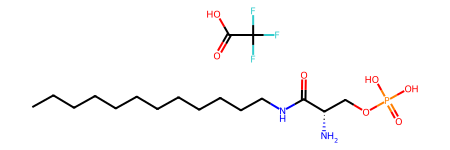

In [17]:
query = Chem.MolFromSmiles('CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F')
query

We start by finding the molregno for the molecule (if there is one). For this we need to prepare the molecule the same way that the original structures were prepared: calling `ChargeParent()` and `AddHs()`:

In [18]:
query = Chem.AddHs(rdMolStandardize.ChargeParent(query))

Get the molregno for any matching topologies in the registration database:

In [19]:
ids = lwreg.query(mol=query)
ids

[4]

Now query for the (molregno,conf_id) pairs for those molregnos:

In [20]:
ids_with_confids = lwreg.query(ids=ids)
ids_with_confids

[(4, 16), (4, 17), (4, 18), (4, 19), (4, 20)]

And now we can actually retrieve the conformers:

In [21]:
t = lwreg.retrieve(ids=ids_with_confids)

The result is a dictory of (molblock, 'mol') two-tuples keyed by (molregno,conf_id):

In [23]:
print(t[(4,16)])

('\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 56 55 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -9.137147 0.038509 1.892044 0\nM  V30 2 C -8.472348 -1.211018 1.334352 0\nM  V30 3 C -6.948083 -1.104256 1.245960 0\nM  V30 4 C -6.470946 -0.047494 0.245940 0\nM  V30 5 C -4.944981 -0.054338 0.117179 0\nM  V30 6 C -4.465898 1.026696 -0.853628 0\nM  V30 7 C -2.939957 1.141712 -0.926906 0\nM  V30 8 C -2.268770 -0.093608 -1.533408 0\nM  V30 9 C -0.774349 0.107391 -1.805515 0\nM  V30 10 C 0.058359 0.260082 -0.530230 0\nM  V30 11 C 1.546383 0.402966 -0.854239 0\nM  V30 12 C 2.385145 0.491099 0.418627 0\nM  V30 13 N 3.781964 0.724951 0.131534 0\nM  V30 14 C 4.635737 -0.265303 -0.302244 0\nM  V30 15 O 4.274513 -1.407697 -0.567221 0\nM  V30 16 C 6.099491 0.188320 -0.429186 0 CFG=1\nM  V30 17 N 6.254782 1.628735 -0.053288 0\nM  V30 18 C 6.983197 -0.709436 0.440509 0\nM  V30 19 O 8.335820 -0.263926 0.348619 0\nM  V30 20 P 9.425287 -1.163159 1.095838 0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

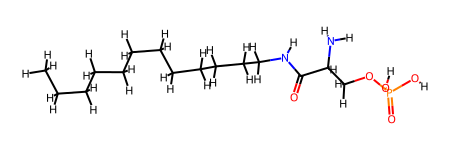

In [26]:
sampleMol = Chem.MolFromMolBlock(t[(4,16)][0],removeHs=False)
sampleMol